In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import pandas as pd

In [2]:
# Load the CSV file
df = pd.read_csv("combined_features.csv")

# Extract paths, labels, and features
loaded_paths = df["path"].tolist()
loaded_labels = df["label"].tolist()
loaded_features = torch.tensor(df["features"].apply(eval).to_list(), dtype=torch.float32)
feats = loaded_features
print(df.head())
print(f"Loaded features shape: {loaded_features.shape}")
print(f"Loaded paths: {len(loaded_paths)}")
print(f"Loaded labels: {len(loaded_labels)}")


                                                path label  \
0  C:\Users\k54739\Bibi_new_thesis\thesis\day7tod...  orig   
1  C:\Users\k54739\Bibi_new_thesis\thesis\day7tod...  orig   
2  C:\Users\k54739\Bibi_new_thesis\thesis\day7tod...  orig   
3  C:\Users\k54739\Bibi_new_thesis\thesis\day7tod...  orig   
4  C:\Users\k54739\Bibi_new_thesis\thesis\day7tod...  orig   

                                            features  
0  [0.0, 0.0, 2.648390054702759, 0.0, 0.0, 1.0987...  
1  [0.0, 0.0, 0.23386812210083008, 0.279474169015...  
2  [0.2127174437046051, 0.0, 0.0, 0.0, 0.21626468...  
3  [0.0, 0.0027299169450998306, 0.709867715835571...  
4  [0.0, 0.0, 0.1180722713470459, 0.0, 0.09159151...  
Loaded features shape: torch.Size([944, 512])
Loaded paths: 944
Loaded labels: 944


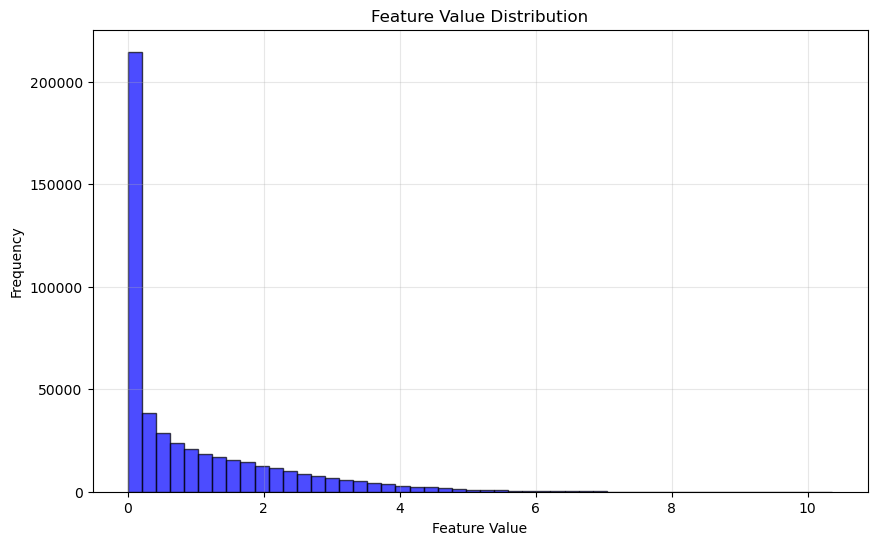

In [3]:
import matplotlib.pyplot as plt

# Flatten the features for plotting (if needed)
flattened_features = feats.flatten().numpy()

# Plot the histogram of feature values
plt.figure(figsize=(10, 6))
plt.hist(flattened_features, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title("Feature Value Distribution")
plt.xlabel("Feature Value")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


# plot z score normalised 

features_mean = feats.mean(dim=0, keepdim=True)
features_std = feats.std(dim=0, keepdim=True)

normalized_features = (feats - features_mean) / features_std

# Check the new distribution
flattened_normalized_features = normalized_features.flatten().numpy()

# Plot the normalized distribution
plt.figure(figsize=(10, 6))
plt.hist(flattened_normalized_features, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title("Normalized Feature Value Distribution (Standardized)")
plt.xlabel("Feature Value")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


torch.Size([944, 512])


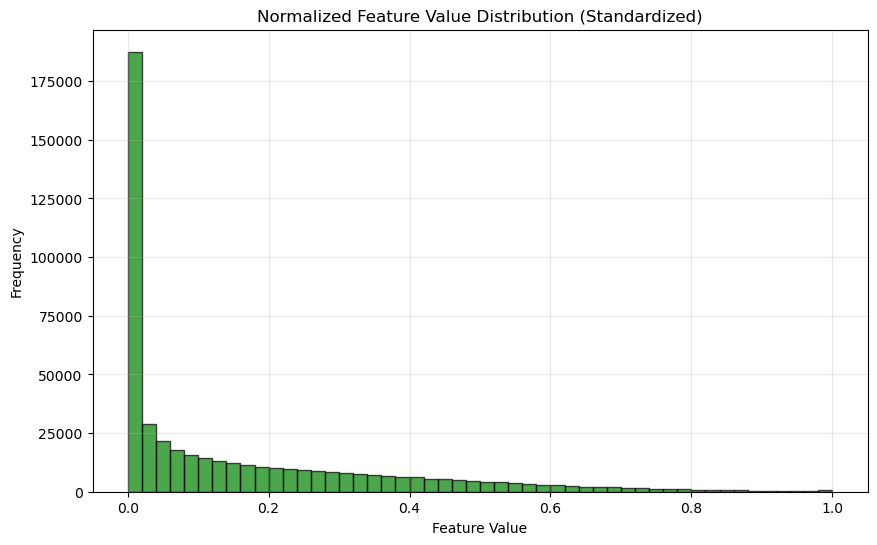

In [4]:
# Min-Max scaling
features_min = feats.min(dim=0, keepdim=True).values  # Minimum value per feature
features_max = feats.max(dim=0, keepdim=True).values  # Maximum value per feature

normalized_feats = (feats - features_min) / (features_max - features_min)
print(normalized_feats.shape)

# Check the new distribution
flattened_normalized_features = normalized_feats.flatten().numpy()

# Plot the normalized distribution
plt.figure(figsize=(10, 6))
plt.hist(flattened_normalized_features, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title("Normalized Feature Value Distribution (Standardized)")
plt.xlabel("Feature Value")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


In [5]:

from torch.utils.data import TensorDataset
dataset = TensorDataset(normalized_feats)
len(dataset)

944

In [6]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

class FeaturePredictor(nn.Module):
    def __init__(self, input_size=512, output_size=512):
        super(FeaturePredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16,8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256, output_size)
        )
    
    def forward(self, x):
        return self.model(x)

In [8]:
model = FeaturePredictor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [9]:


optimizer_class = torch.optim.Adam

from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
import numpy as np
import torch


In [10]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0.0):
        """
        Args:
            patience (int): How many epochs to wait after the last validation loss improvement.
            delta (float): Minimum change in the validation loss to qualify as an improvement.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.no_improvement_epochs = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.no_improvement_epochs = 0
        else:
            self.no_improvement_epochs += 1
            if self.no_improvement_epochs >= self.patience:
                self.early_stop = True


def cross_validate_with_early_stopping(
    model_class, dataset, criterion, optimizer_class, num_epochs=50, n_splits=5, patience=10, delta=0.0, device='cuda'
):
    """
    Cross-validation with early stopping.

    Args:
        model_class: The model class to initialize.
        dataset: The dataset to perform cross-validation on.
        criterion: Loss function.
        optimizer_class: Optimizer class to use.
        num_epochs: Maximum number of epochs for training.
        n_splits: Number of cross-validation splits.
        patience: Number of epochs to wait for validation loss improvement.
        delta: Minimum change in validation loss to consider as improvement.
        device: Device to run the model on ('cuda' or 'cpu').

    Returns:
        histories: A list of training/validation loss histories for each fold.
        best_models: A list of best model states for each fold.
    """
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    histories = []
    best_models = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}/{n_splits}")

        # Create subsets for this fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Create DataLoaders
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

        # Initialize the model, optimizer, and early stopping for this fold
        model = model_class().to(device)
        optimizer = optimizer_class(model.parameters(), lr=1e-4)
        early_stopping = EarlyStopping(patience=patience, delta=delta)  # Pass delta here

        # Training and validation loop
        history = {'train_loss': [], 'val_loss': []}
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0.0
            for batch_feats in train_loader:
                batch_feats = batch_feats[0].to(device)

                # Forward pass
                outputs = model(batch_feats)
                loss = criterion(outputs, batch_feats)
                train_loss += loss.item()

                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            train_loss /= len(train_loader)
            history['train_loss'].append(train_loss)

            # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch_feats in val_loader:
                    batch_feats = batch_feats[0].to(device)
                    outputs = model(batch_feats)
                    loss = criterion(outputs, batch_feats)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            history['val_loss'].append(val_loss)

            print(f"Epoch [{epoch + 1}/{num_epochs}] Fold {fold + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Check early stopping
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch + 1} for fold {fold + 1}")
                break

        # Save the best model for this fold
        best_models.append(model.state_dict())
        histories.append(history)

    return histories, best_models



In [11]:
cv_histories, best_models = cross_validate_with_early_stopping(
    model_class=FeaturePredictor,
    dataset=dataset,
    criterion=nn.MSELoss(),
    optimizer_class=torch.optim.Adam,
    num_epochs=4000,
    patience=500,
    delta=0.0000  # Example delta value
)


Fold 1/5
Epoch [1/4000] Fold 1, Train Loss: 0.0654, Val Loss: 0.0619
Epoch [2/4000] Fold 1, Train Loss: 0.0598, Val Loss: 0.0557
Epoch [3/4000] Fold 1, Train Loss: 0.0526, Val Loss: 0.0479
Epoch [4/4000] Fold 1, Train Loss: 0.0450, Val Loss: 0.0418
Epoch [5/4000] Fold 1, Train Loss: 0.0407, Val Loss: 0.0394
Epoch [6/4000] Fold 1, Train Loss: 0.0392, Val Loss: 0.0387
Epoch [7/4000] Fold 1, Train Loss: 0.0386, Val Loss: 0.0383
Epoch [8/4000] Fold 1, Train Loss: 0.0382, Val Loss: 0.0380
Epoch [9/4000] Fold 1, Train Loss: 0.0378, Val Loss: 0.0375
Epoch [10/4000] Fold 1, Train Loss: 0.0373, Val Loss: 0.0368
Epoch [11/4000] Fold 1, Train Loss: 0.0368, Val Loss: 0.0359
Epoch [12/4000] Fold 1, Train Loss: 0.0359, Val Loss: 0.0350
Epoch [13/4000] Fold 1, Train Loss: 0.0352, Val Loss: 0.0345
Epoch [14/4000] Fold 1, Train Loss: 0.0349, Val Loss: 0.0342
Epoch [15/4000] Fold 1, Train Loss: 0.0346, Val Loss: 0.0339
Epoch [16/4000] Fold 1, Train Loss: 0.0344, Val Loss: 0.0338
Epoch [17/4000] Fold 1, 

# delta = 0

In [12]:
# Example: Average validation loss across folds
avg_val_loss = np.mean([history['val_loss'][-1] for history in cv_histories])
print(f"Average Validation Loss: {avg_val_loss:.4f}")


Average Validation Loss: 0.0156


In [13]:
# Analyze the best results for each fold outside the training function
for fold_idx, history in enumerate(cv_histories):
    # Find the epoch with the lowest validation loss
    best_epoch = int(np.argmin(history['val_loss'])) + 1  # Adding 1 because epochs are 1-indexed
    best_val_loss = history['val_loss'][best_epoch - 1]  # Accessing the loss using 0-based index
    best_train_loss = history['train_loss'][best_epoch - 1]

    print(f"Fold {fold_idx + 1}:")
    print(f"  Best Validation Loss = {best_val_loss:.4f}")
    print(f"  Corresponding Training Loss = {best_train_loss:.4f}")
    print(f"  Best Epoch = {best_epoch}")


Fold 1:
  Best Validation Loss = 0.0142
  Corresponding Training Loss = 0.0036
  Best Epoch = 2731
Fold 2:
  Best Validation Loss = 0.0133
  Corresponding Training Loss = 0.0061
  Best Epoch = 1533
Fold 3:
  Best Validation Loss = 0.0176
  Corresponding Training Loss = 0.0115
  Best Epoch = 829
Fold 4:
  Best Validation Loss = 0.0189
  Corresponding Training Loss = 0.0094
  Best Epoch = 967
Fold 5:
  Best Validation Loss = 0.0124
  Corresponding Training Loss = 0.0032
  Best Epoch = 3533


In [15]:
def plot_loss_curves_separately(cv_histories):
    """
    Plot training and validation loss curves for each fold in separate figures.
    
    Args:
        cv_histories (list): List of loss histories for each fold.
    """
    # Plot Training Loss
    plt.figure(figsize=(10, 6))
    for fold, history in enumerate(cv_histories):
        epochs = range(1, len(history['train_loss']) + 1)  # Dynamically set range
        plt.plot(epochs, history['train_loss'], label=f'Fold {fold + 1} Train Loss')
    plt.title('Training Loss per Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Validation Loss
    plt.figure(figsize=(10, 6))
    for fold, history in enumerate(cv_histories):
        epochs = range(1, len(history['val_loss']) + 1)  # Dynamically set range
        plt.plot(epochs, history['val_loss'], label=f'Fold {fold + 1} Val Loss', linestyle='--')
    plt.title('Validation Loss per Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


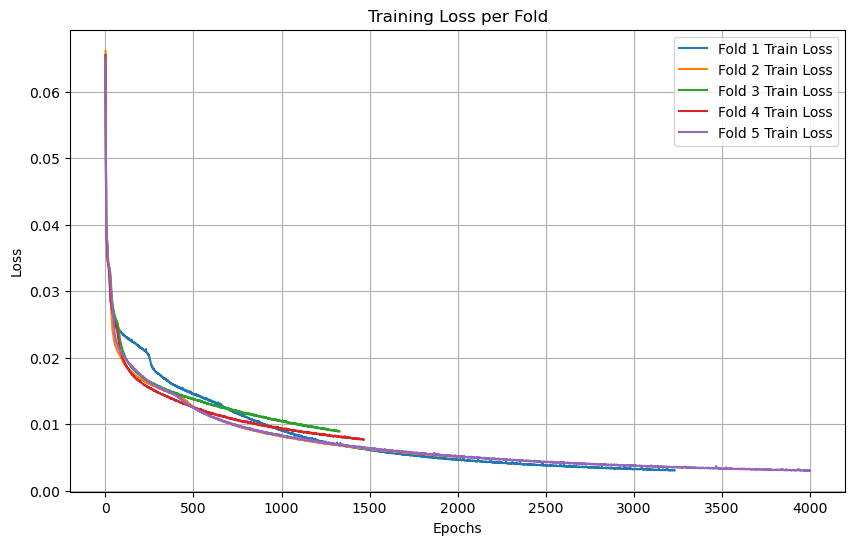

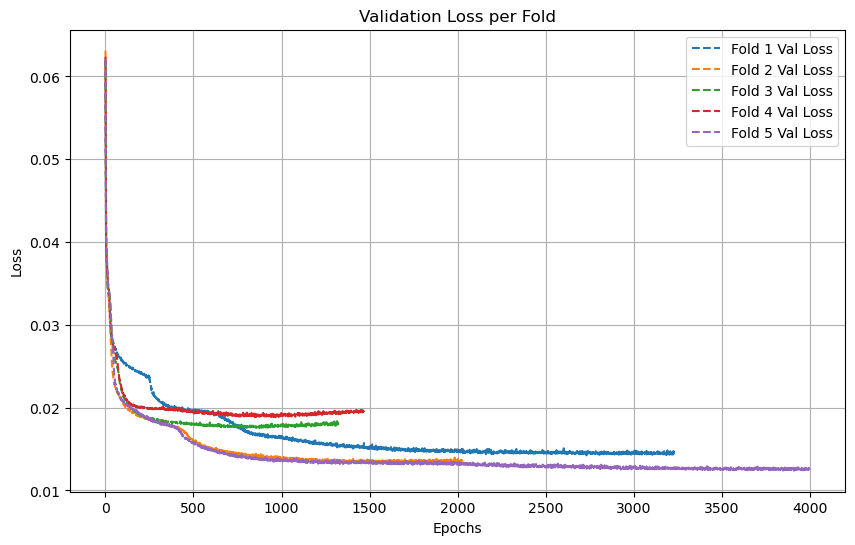

In [16]:
import matplotlib.pyplot as plt
plot_loss_curves_separately(cv_histories)


In [17]:
import os

# Define the directory where models will be saved (current folder)
save_dir = "."  # Current directory
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist (optional for ".")

# Save each fold's best model to the directory
for i, model_state in enumerate(best_models):
    save_path = os.path.join(save_dir, f'best_model_fold_{i+1}.pth')
    torch.save(model_state, save_path)

print(f"Models saved to the current directory: {save_dir}")

Models saved to the current directory: .


# inference

In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import pandas as pd

In [2]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

class FeaturePredictor(nn.Module):
    def __init__(self, input_size=512, output_size=512):
        super(FeaturePredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16,8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256, output_size)
        )
    
    def forward(self, x):
        return self.model(x)

In [3]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import torch

# Define the path to the specific model file
model_path = './best_model_fold_5.pth'

# Load the saved model state dictionary
model_state = torch.load(model_path)

# Initialize the model and load the state dictionary
model = FeaturePredictor()  # Replace with your model class
model.load_state_dict(model_state)
model.to(device)
model.eval()

print("Model loaded successfully.")


Model loaded successfully.


C:\Users\k54739\AppData\Local\Temp\ipykernel_16116\2248955768.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load(model_path)


In [5]:
# Load the CSV file
df = pd.read_csv("cond10_feats.csv")

# Extract paths, labels, and features
loaded_paths = df["path"].tolist()
loaded_features = torch.tensor(df["features"].apply(eval).to_list(), dtype=torch.float32)
print(df.head())
print(f"Loaded features shape: {loaded_features.shape}")
print(f"Loaded paths: {len(loaded_paths)}")



                                                path  \
0  C:\Users\k54739\Bibi_new_thesis\thesis\day10to...   
1  C:\Users\k54739\Bibi_new_thesis\thesis\day10to...   
2  C:\Users\k54739\Bibi_new_thesis\thesis\day10to...   
3  C:\Users\k54739\Bibi_new_thesis\thesis\day10to...   
4  C:\Users\k54739\Bibi_new_thesis\thesis\day10to...   

                                            features  
0  [0.9737608432769775, 1.125008463859558, 0.0, 2...  
1  [0.3584423065185547, 1.7659645080566406, 0.0, ...  
2  [0.0, 0.956384539604187, 0.02348867990076542, ...  
3  [0.0, 0.914495050907135, 0.09288834035396576, ...  
4  [0.06423236429691315, 1.2180097103118896, 0.0,...  
Loaded features shape: torch.Size([199, 512])
Loaded paths: 199


# Load the CSV file
df = pd.read_csv("combined_features.csv")

# Extract paths, labels, and features
loaded_paths = df["path"].tolist()
loaded_labels = df["label"].tolist()
loaded_features = torch.tensor(df["features"].apply(eval).to_list(), dtype=torch.float32)
feats = loaded_features
print(df.head())
print(f"Loaded features shape: {loaded_features.shape}")
print(f"Loaded paths: {len(loaded_paths)}")
print(f"Loaded labels: {len(loaded_labels)}")


# Min-Max scaling
features_min = feats.min(dim=0, keepdim=True).values  # Minimum value per feature
features_max = feats.max(dim=0, keepdim=True).values  # Maximum value per feature

normalized_feats = (feats - features_min) / (features_max - features_min)
print(normalized_feats.shape)

# Save features_min and features_max
torch.save(features_min, "train_min.pth")
torch.save(features_max, "train_max.pth")

print("Features min and max saved successfully.")


In [6]:
# Load features_min and features_max
loaded_features_min = torch.load("train_min.pth")
loaded_features_max = torch.load("train_max.pth")
print(loaded_features_min.shape)
print(loaded_features_max.shape)


print("Features min and max loaded successfully.")


torch.Size([1, 512])
torch.Size([1, 512])
Features min and max loaded successfully.


C:\Users\k54739\AppData\Local\Temp\ipykernel_16116\3524933051.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_features_min = torch.load("train_min.pth")
C:\Users\

In [7]:
normalized_feats = (loaded_features - loaded_features_min) / (loaded_features_max - loaded_features_min)
print(normalized_feats.shape)

torch.Size([199, 512])


In [8]:
# Assuming normalized_feats is a tensor of shape [num_samples, num_features]
inference_dataset = TensorDataset(normalized_feats)
inference_loader = DataLoader(inference_dataset, batch_size=32, shuffle=False)


In [9]:
# Define a prefix for the group of images (e.g., "original" or "augmented")
prefix =  "cond10" #"cond7"    # Change this for different groups, e.g., "augmented", "group1"

# Perform inference
mse_errors = []
euclidean_distances = []
cosine_distances = []

# Use the same criterion as during training
criterion = nn.MSELoss(reduction='none')  # Use 'none' to calculate loss per sample

with torch.no_grad():
    for batch_feats in inference_loader:
        # Extract features
        batch_feats = batch_feats[0].to(device)
        outputs = model(batch_feats)

        # Calculate MSE loss for each feature vector
        batch_mse = criterion(outputs, batch_feats).mean(dim=1)  # MSE per sample
        mse_errors.extend(batch_mse.cpu().numpy())

        # Calculate Euclidean distance for each feature vector
        batch_euclidean = torch.norm(outputs - batch_feats, p=2, dim=1)  # L2 norm
        euclidean_distances.extend(batch_euclidean.cpu().numpy())

        # Calculate Cosine distance for each feature vector
        batch_cosine_similarity = torch.nn.functional.cosine_similarity(outputs, batch_feats, dim=1)
        batch_cosine_distance = 1 - batch_cosine_similarity  # Cosine distance = 1 - Cosine similarity
        cosine_distances.extend(batch_cosine_distance.cpu().numpy())

# Convert results to numpy arrays for further analysis
mse_errors = np.array(mse_errors)
euclidean_distances = np.array(euclidean_distances)
cosine_distances = np.array(cosine_distances)

# Save the results with the prefix
np.save(f"{prefix}_mse_errors.npy", mse_errors)
np.save(f"{prefix}_euclidean_distances.npy", euclidean_distances)
np.save(f"{prefix}_cosine_distances.npy", cosine_distances)

print(f"Errors and distances for group '{prefix}' saved successfully.")


Errors and distances for group 'cond10' saved successfully.


In [10]:
prefix = "cond10"  #"cond7"  # Replace with your specific prefix

# Load the saved metrics
cond7_mse_errors = np.load(f"{prefix}_mse_errors.npy")
cond7_euclidean_distances = np.load(f"{prefix}_euclidean_distances.npy")
cond7_cosine_distances = np.load(f"{prefix}_cosine_distances.npy")
cond7_mse_errors.shape

(199,)

C:\Users\k54739\AppData\Local\Temp\ipykernel_16116\3256272314.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data, labels=labels, patch_artist=True,


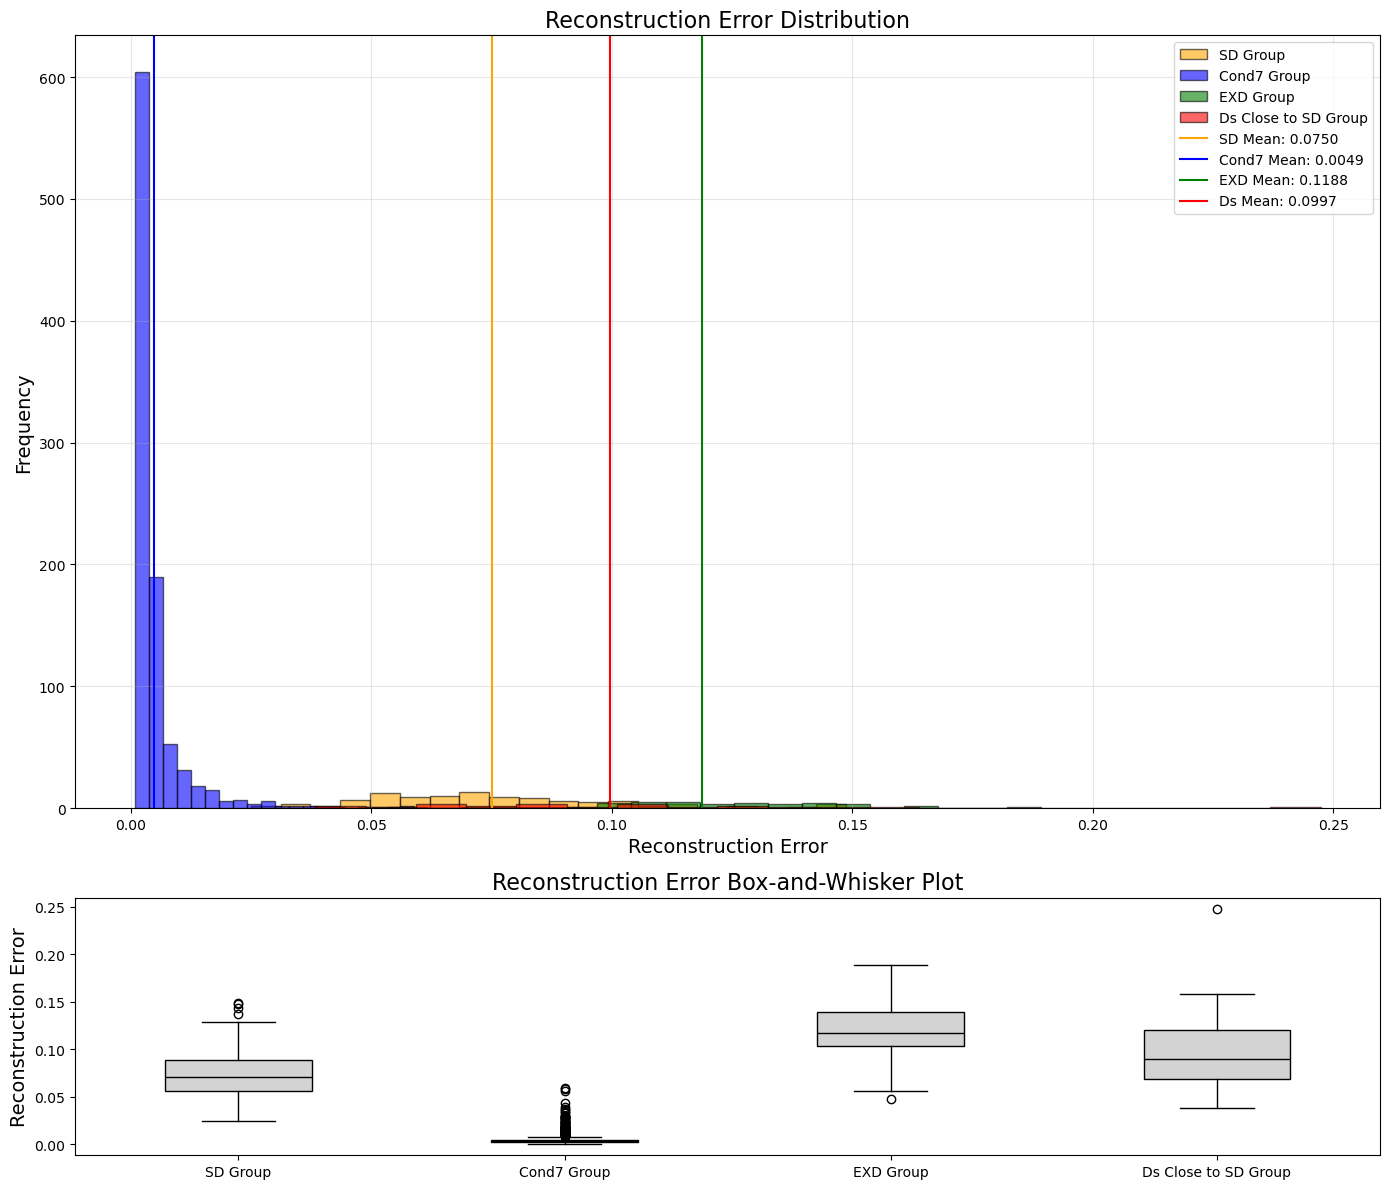

C:\Users\k54739\AppData\Local\Temp\ipykernel_16116\3256272314.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data, labels=labels, patch_artist=True,


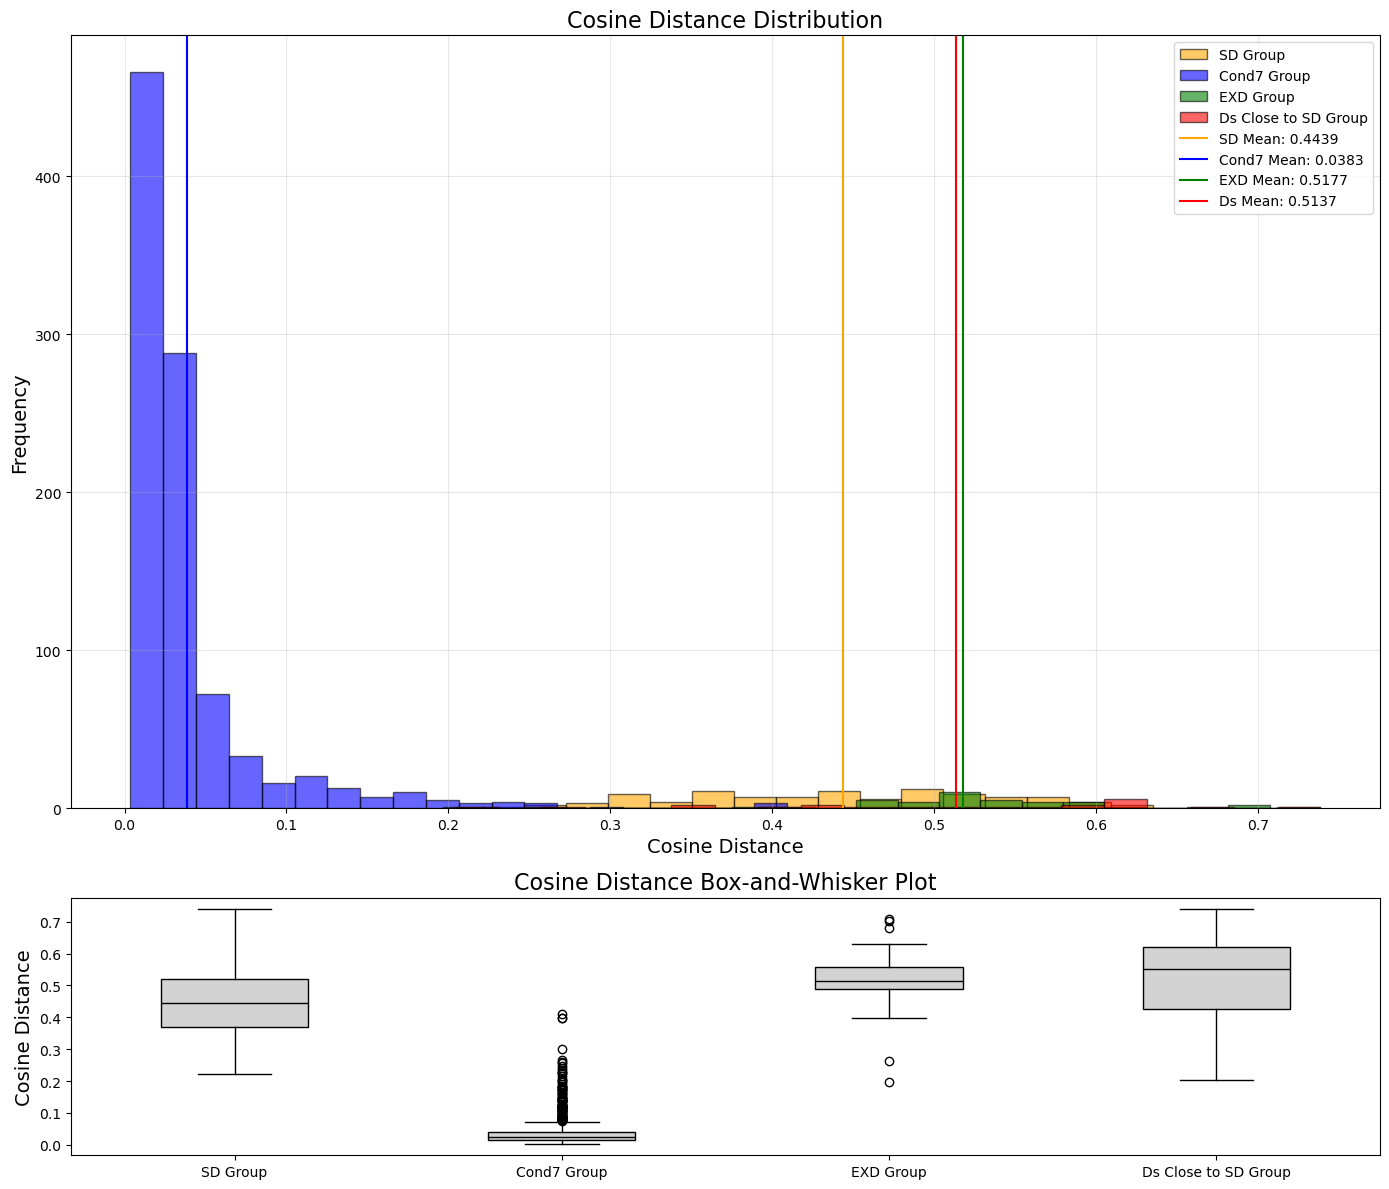

C:\Users\k54739\AppData\Local\Temp\ipykernel_16116\3256272314.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data, labels=labels, patch_artist=True,


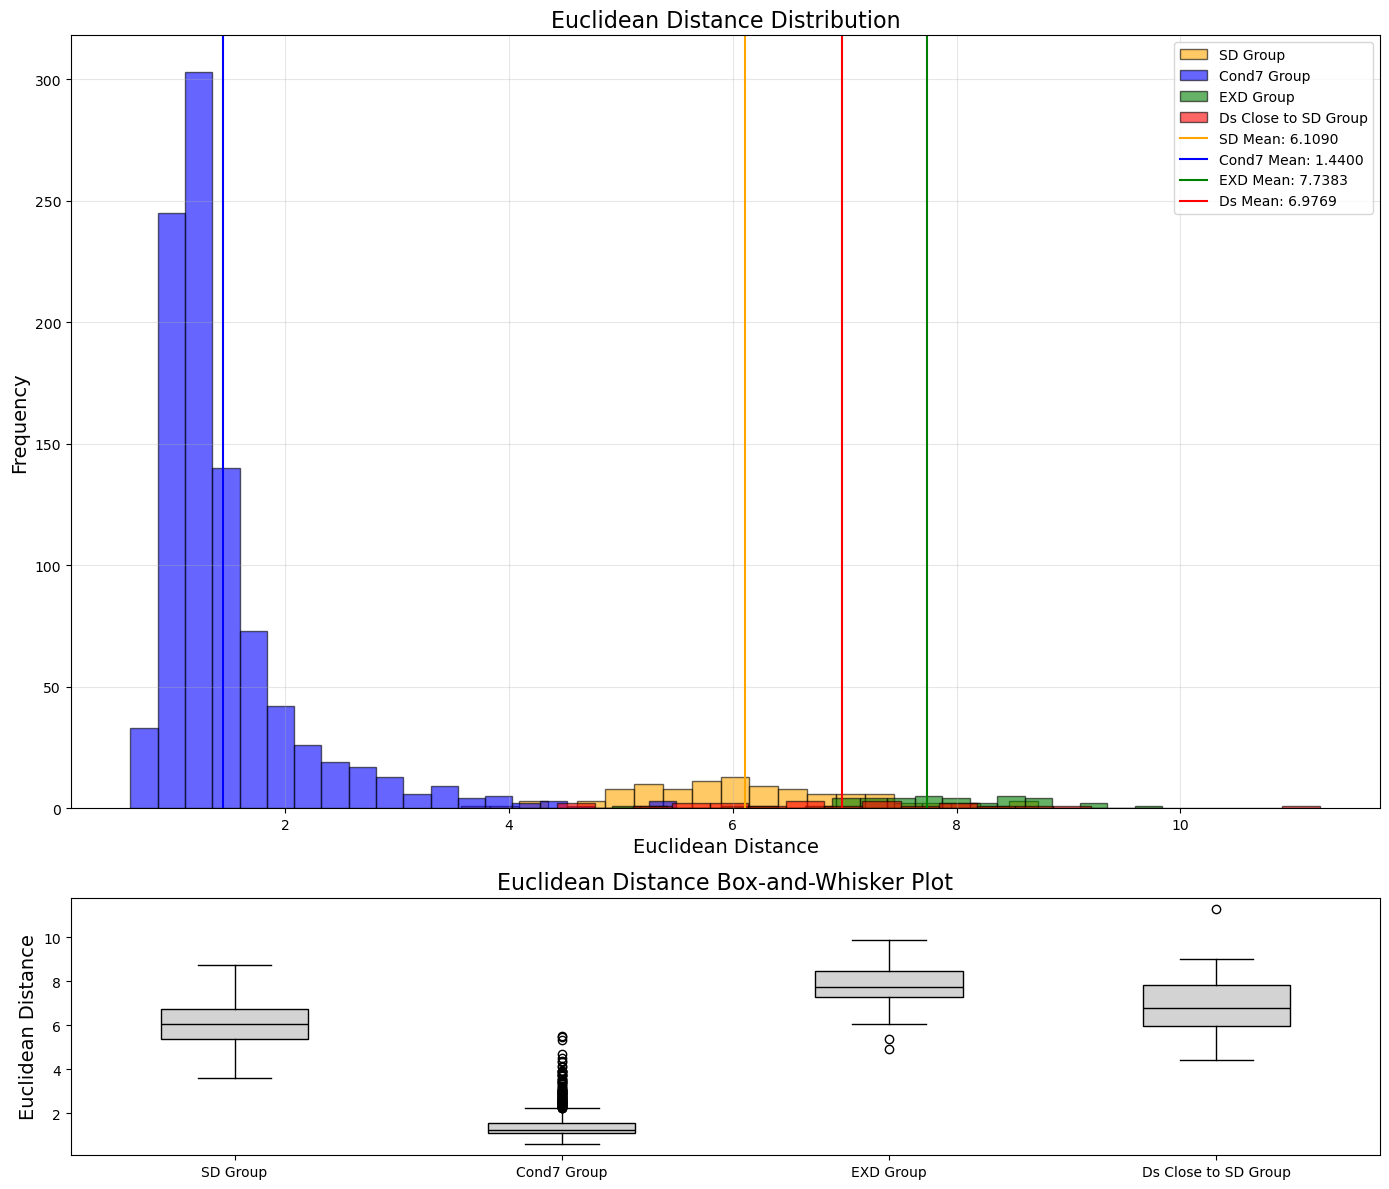

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_distributions_with_boxplot(sd_metrics, control_metrics, exd_metrics, ds_metrics, metric_names, bins=20):
    """
    Plots the histogram and box-and-whisker plots for multiple metrics across multiple groups.

    Args:
        sd_metrics (dict): Dictionary of metrics for the SD group. Keys are metric names, values are arrays.
        control_metrics (dict): Dictionary of metrics for the Control group. Keys are metric names, values are arrays.
        exd_metrics (dict): Dictionary of metrics for the EXD group. Keys are metric names, values are arrays.
        ds_metrics (dict): Dictionary of metrics for the Ds Close to SD group. Keys are metric names, values are arrays.
        metric_names (list): Names of the metrics to plot (e.g., ["Reconstruction Error", "Cosine Distance"]).
        bins (int): Number of bins for the histogram.
    """
    for metric_name in metric_names:
        # Extract metrics for all groups
        sd_values = sd_metrics[metric_name]
        control_values = control_metrics[metric_name]
        exd_values = exd_metrics[metric_name]
        ds_values = ds_metrics[metric_name]

        # Create figure with two subplots: Histogram (top) and Boxplot (bottom)
        fig, axes = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [3, 1]})

        # Histogram
        axes[0].hist(sd_values, bins=bins, alpha=0.6, label="SD Group", color="orange", edgecolor="black")
        axes[0].hist(control_values, bins=bins, alpha=0.6, label="Cond7 Group", color="blue", edgecolor="black")
        axes[0].hist(exd_values, bins=bins, alpha=0.6, label="EXD Group", color="green", edgecolor="black")
        axes[0].hist(ds_values, bins=bins, alpha=0.6, label="Ds Close to SD Group", color="red", edgecolor="black")

        # Add mean lines to the histogram
        axes[0].axvline(np.mean(sd_values), color='orange', linestyle='-', label=f"SD Mean: {np.mean(sd_values):.4f}")
        axes[0].axvline(np.mean(control_values), color='blue', linestyle='-', label=f"Cond7 Mean: {np.mean(control_values):.4f}")
        axes[0].axvline(np.mean(exd_values), color='green', linestyle='-', label=f"EXD Mean: {np.mean(exd_values):.4f}")
        axes[0].axvline(np.mean(ds_values), color='red', linestyle='-', label=f"Ds Mean: {np.mean(ds_values):.4f}")

        # Add title and legend to the histogram
        axes[0].set_title(f"{metric_name} Distribution", fontsize=16)
        axes[0].set_xlabel(metric_name, fontsize=14)
        axes[0].set_ylabel("Frequency", fontsize=14)
        axes[0].legend(fontsize=10)
        axes[0].grid(alpha=0.3)

        # Box-and-whisker plot
        data = [sd_values, control_values, exd_values, ds_values]
        labels = ["SD Group", "Cond7 Group", "EXD Group", "Ds Close to SD Group"]
        axes[1].boxplot(data, labels=labels, patch_artist=True, 
                        boxprops=dict(facecolor="lightgrey", color="black"),
                        medianprops=dict(color="black"), whiskerprops=dict(color="black"))

        # Add title and labels to the boxplot
        axes[1].set_title(f"{metric_name} Box-and-Whisker Plot", fontsize=16)
        axes[1].set_ylabel(metric_name, fontsize=14)

        # Adjust layout and show the plot
        plt.tight_layout()
        plt.show()

# Example Usage
if __name__ == "__main__":
    # Load the metrics for SD and Control groups
    sd_metrics = {
        "Reconstruction Error": np.load("sd_mse_errors.npy"),
        "Cosine Distance": np.load("sd_cosine_distances.npy"),
        "Euclidean Distance": np.load("sd_euclidean_distances.npy")
    }

    control_metrics = {
        "Reconstruction Error": np.load("cond7_mse_errors.npy"),
        "Cosine Distance": np.load("cond7_cosine_distances.npy"),
        "Euclidean Distance": np.load("cond7_euclidean_distances.npy")
    }

    # Load the metrics for EXD and Ds Close to SD groups
    exd_metrics = {
        "Reconstruction Error": np.load("ex_mse_errors.npy"),
        "Cosine Distance": np.load("ex_cosine_distances.npy"),
        "Euclidean Distance": np.load("ex_euclidean_distances.npy")
    }

    ds_metrics = {
        "Reconstruction Error": np.load("ds_closeto_sd_mse_errors.npy"),
        "Cosine Distance": np.load("ds_closeto_sd_cosine_distances.npy"),
        "Euclidean Distance": np.load("ds_closeto_sd_euclidean_distances.npy")
    }

    # Define the metric names
    metric_names = ["Reconstruction Error", "Cosine Distance", "Euclidean Distance"]

    # Plot distributions with boxplots
    plot_distributions_with_boxplot(sd_metrics, control_metrics, exd_metrics, ds_metrics, metric_names)


C:\Users\k54739\AppData\Local\Temp\ipykernel_16116\3134692173.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data, labels=labels, patch_artist=True,


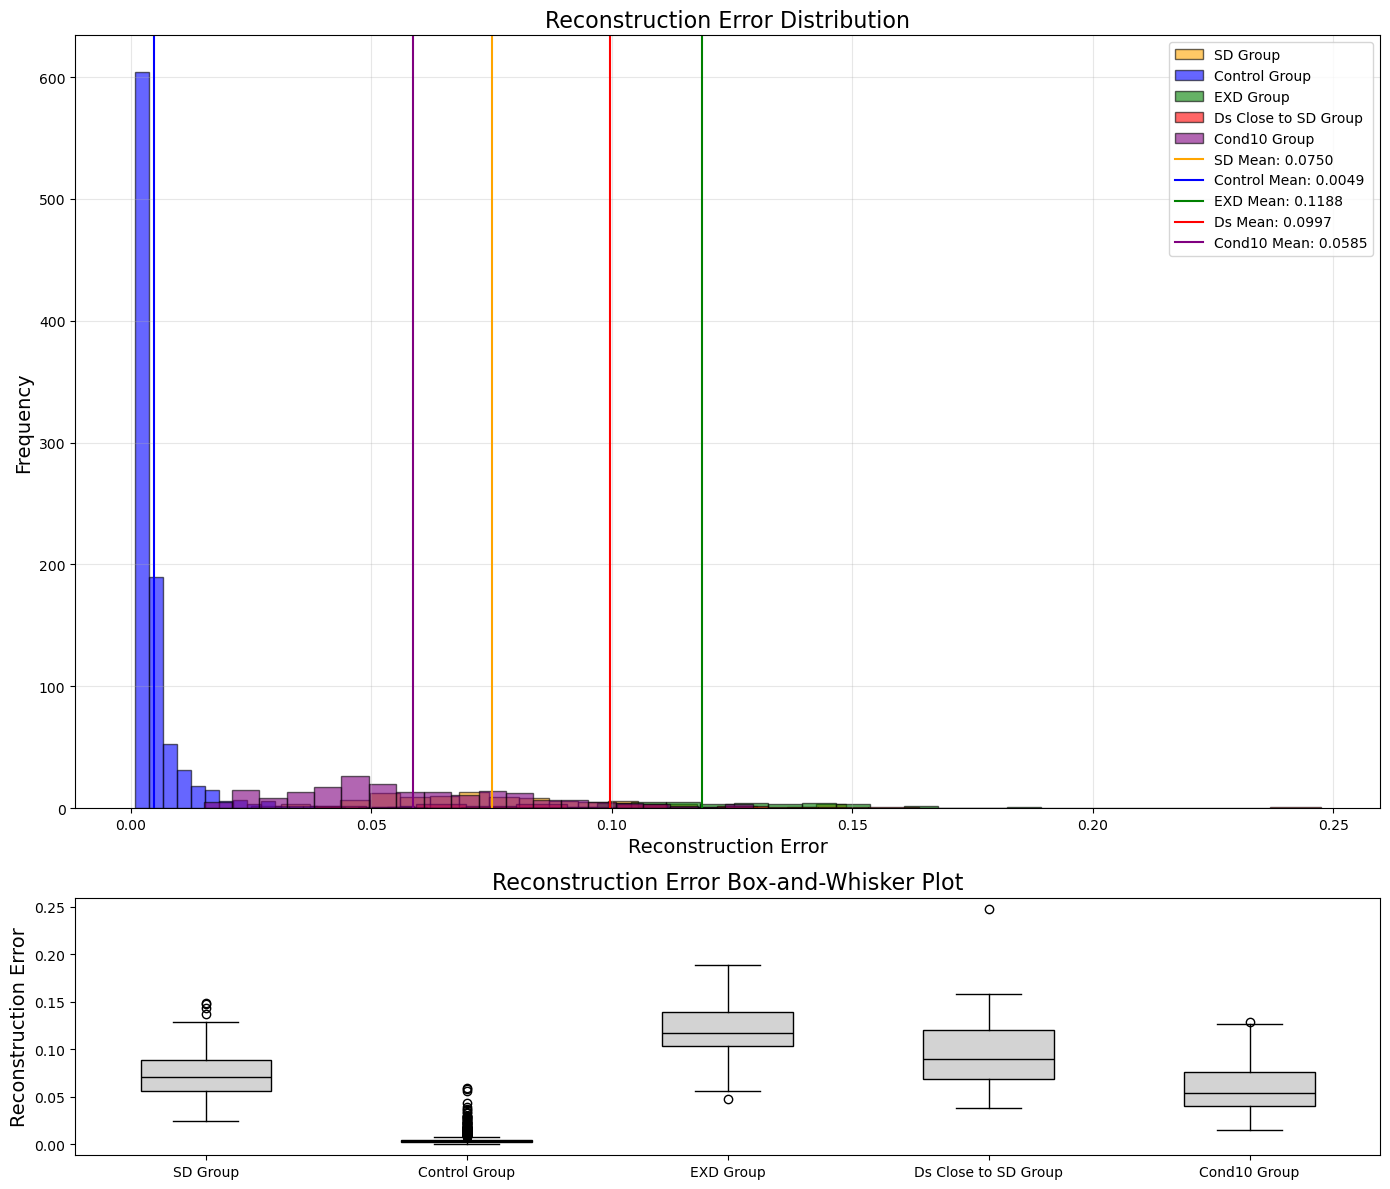

C:\Users\k54739\AppData\Local\Temp\ipykernel_16116\3134692173.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data, labels=labels, patch_artist=True,


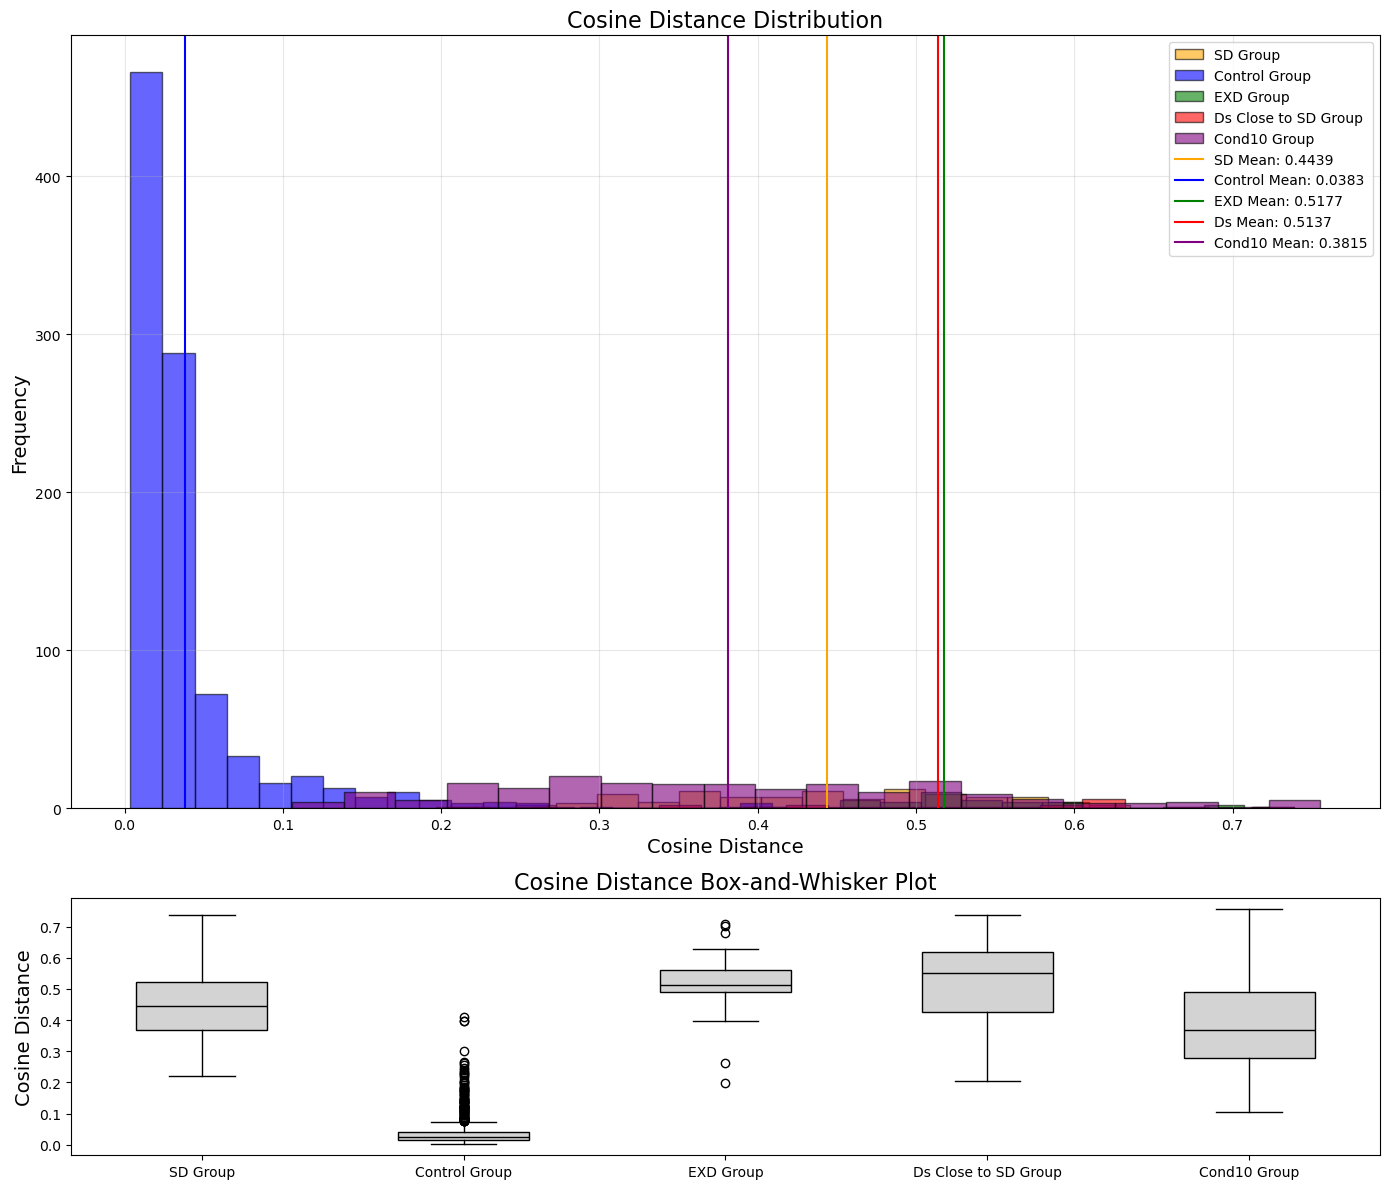

C:\Users\k54739\AppData\Local\Temp\ipykernel_16116\3134692173.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data, labels=labels, patch_artist=True,


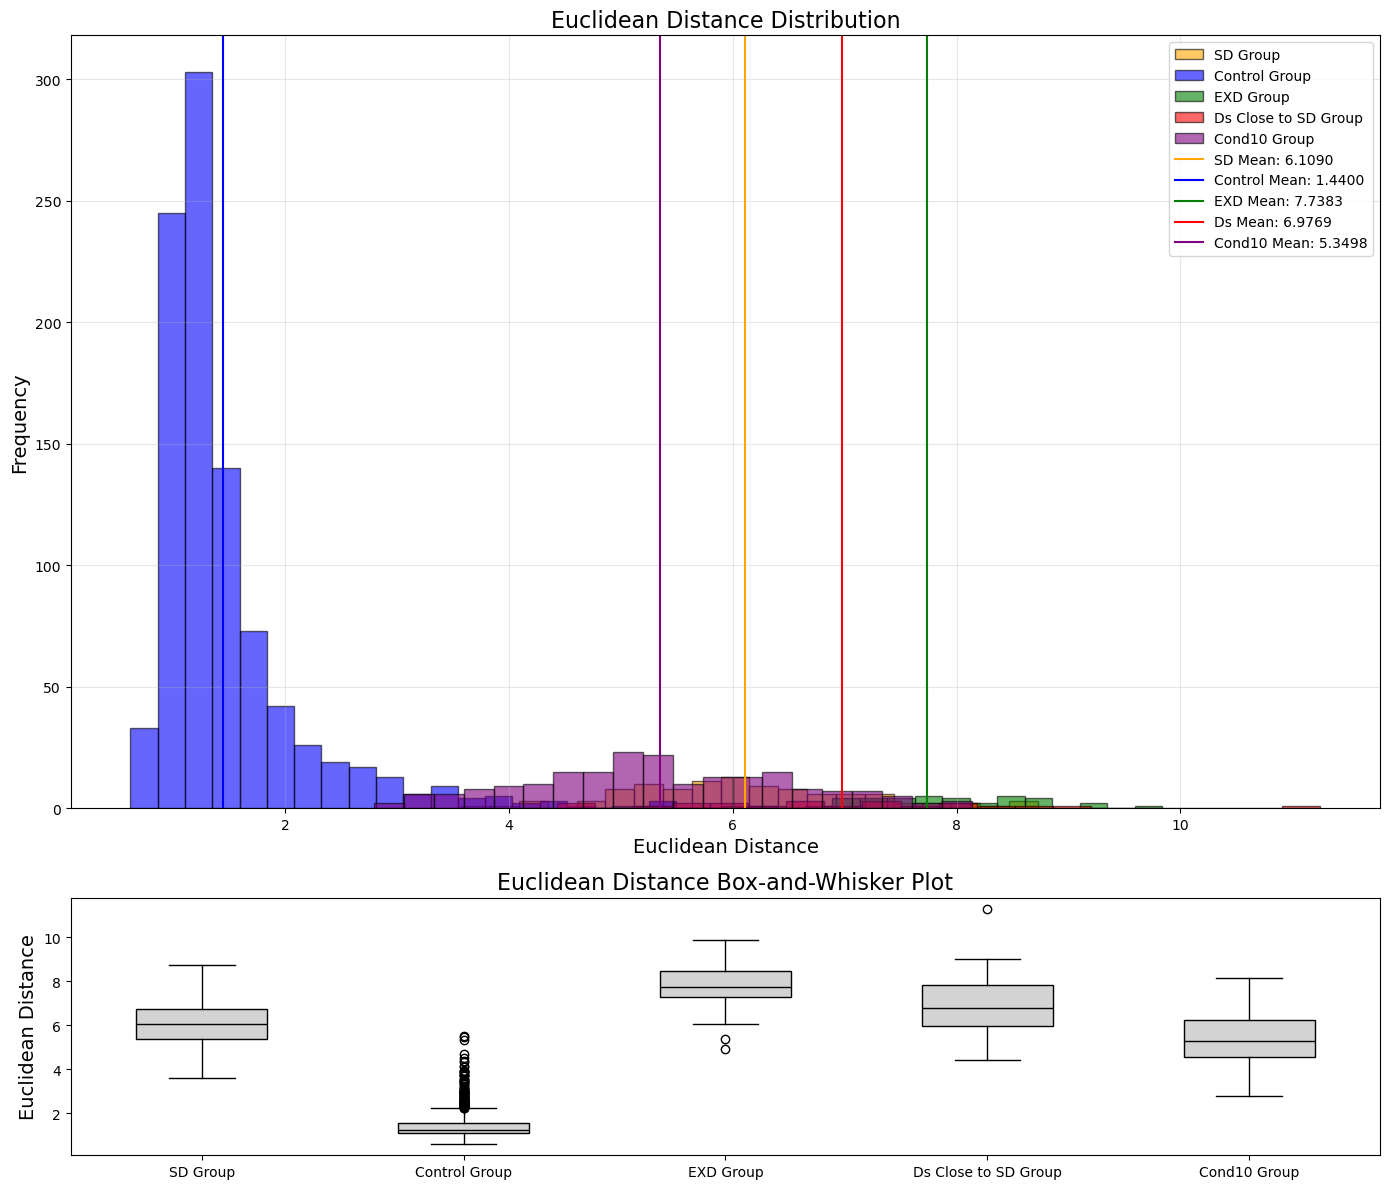

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_distributions_with_boxplot(sd_metrics, control_metrics, exd_metrics, ds_metrics, cond_metrics, metric_names, bins=20):
    """
    Plots the histogram and box-and-whisker plots for multiple metrics across multiple groups.

    Args:
        sd_metrics (dict): Dictionary of metrics for the SD group. Keys are metric names, values are arrays.
        control_metrics (dict): Dictionary of metrics for the Control group. Keys are metric names, values are arrays.
        exd_metrics (dict): Dictionary of metrics for the EXD group. Keys are metric names, values are arrays.
        ds_metrics (dict): Dictionary of metrics for the Ds Close to SD group. Keys are metric names, values are arrays.
        cond_metrics (dict): Dictionary of metrics for the Cond10 group. Keys are metric names, values are arrays.
        metric_names (list): Names of the metrics to plot (e.g., ["Reconstruction Error", "Cosine Distance"]).
        bins (int): Number of bins for the histogram.
    """
    for metric_name in metric_names:
        # Extract metrics for all groups
        sd_values = sd_metrics[metric_name]
        control_values = control_metrics[metric_name]
        exd_values = exd_metrics[metric_name]
        ds_values = ds_metrics[metric_name]
        cond_values = cond_metrics[metric_name]

        # Create figure with two subplots: Histogram (top) and Boxplot (bottom)
        fig, axes = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [3, 1]})

        # Histogram
        axes[0].hist(sd_values, bins=bins, alpha=0.6, label="SD Group", color="orange", edgecolor="black")
        axes[0].hist(control_values, bins=bins, alpha=0.6, label="Control Group", color="blue", edgecolor="black")
        axes[0].hist(exd_values, bins=bins, alpha=0.6, label="EXD Group", color="green", edgecolor="black")
        axes[0].hist(ds_values, bins=bins, alpha=0.6, label="Ds Close to SD Group", color="red", edgecolor="black")
        axes[0].hist(cond_values, bins=bins, alpha=0.6, label="Cond10 Group", color="purple", edgecolor="black")

        # Add mean lines to the histogram
        axes[0].axvline(np.mean(sd_values), color='orange', linestyle='-', label=f"SD Mean: {np.mean(sd_values):.4f}")
        axes[0].axvline(np.mean(control_values), color='blue', linestyle='-', label=f"Control Mean: {np.mean(control_values):.4f}")
        axes[0].axvline(np.mean(exd_values), color='green', linestyle='-', label=f"EXD Mean: {np.mean(exd_values):.4f}")
        axes[0].axvline(np.mean(ds_values), color='red', linestyle='-', label=f"Ds Mean: {np.mean(ds_values):.4f}")
        axes[0].axvline(np.mean(cond_values), color='purple', linestyle='-', label=f"Cond10 Mean: {np.mean(cond_values):.4f}")

        # Add title and legend to the histogram
        axes[0].set_title(f"{metric_name} Distribution", fontsize=16)
        axes[0].set_xlabel(metric_name, fontsize=14)
        axes[0].set_ylabel("Frequency", fontsize=14)
        axes[0].legend(fontsize=10)
        axes[0].grid(alpha=0.3)

        # Box-and-whisker plot
        data = [sd_values, control_values, exd_values, ds_values, cond_values]
        labels = ["SD Group", "Control Group", "EXD Group", "Ds Close to SD Group", "Cond10 Group"]
        axes[1].boxplot(data, labels=labels, patch_artist=True, 
                        boxprops=dict(facecolor="lightgrey", color="black"),
                        medianprops=dict(color="black"), whiskerprops=dict(color="black"))

        # Add title and labels to the boxplot
        axes[1].set_title(f"{metric_name} Box-and-Whisker Plot", fontsize=16)
        axes[1].set_ylabel(metric_name, fontsize=14)

        # Adjust layout and show the plot
        plt.tight_layout()
        plt.show()

# Example Usage
if __name__ == "__main__":
    # Load the metrics for SD and Control groups
    sd_metrics = {
        "Reconstruction Error": np.load("sd_mse_errors.npy"),
        "Cosine Distance": np.load("sd_cosine_distances.npy"),
        "Euclidean Distance": np.load("sd_euclidean_distances.npy")
    }

    control_metrics = {
        "Reconstruction Error": np.load("cond7_mse_errors.npy"),
        "Cosine Distance": np.load("cond7_cosine_distances.npy"),
        "Euclidean Distance": np.load("cond7_euclidean_distances.npy")
    }

    # Load the metrics for EXD and Ds Close to SD groups
    exd_metrics = {
        "Reconstruction Error": np.load("ex_mse_errors.npy"),
        "Cosine Distance": np.load("ex_cosine_distances.npy"),
        "Euclidean Distance": np.load("ex_euclidean_distances.npy")
    }

    ds_metrics = {
        "Reconstruction Error": np.load("ds_closeto_sd_mse_errors.npy"),
        "Cosine Distance": np.load("ds_closeto_sd_cosine_distances.npy"),
        "Euclidean Distance": np.load("ds_closeto_sd_euclidean_distances.npy")
    }

    # Load the metrics for Cond10 group
    cond_metrics = {
        "Reconstruction Error": np.load("cond10_mse_errors.npy"),
        "Cosine Distance": np.load("cond10_cosine_distances.npy"),
        "Euclidean Distance": np.load("cond10_euclidean_distances.npy")
    }

    # Define the metric names
    metric_names = ["Reconstruction Error", "Cosine Distance", "Euclidean Distance"]

    # Plot distributions with boxplots
    plot_distributions_with_boxplot(sd_metrics, control_metrics, exd_metrics, ds_metrics, cond_metrics, metric_names)


import matplotlib.pyplot as plt
import numpy as np

# Load the saved metrics
prefix = "ds_closeto_sd"  # Adjust to the prefix you used
mse_errors = np.load(f"{prefix}_mse_errors.npy")
euclidean_distances = np.load(f"{prefix}_euclidean_distances.npy")
cosine_distances = np.load(f"{prefix}_cosine_distances.npy")

# Plot MSE Errors
plt.figure(figsize=(10, 6))
plt.hist(mse_errors, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title(f"{prefix} - MSE Errors", fontsize=16)
plt.xlabel("MSE Error", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(alpha=0.3)
plt.show()

# Plot Euclidean Distances
plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances, bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title(f"{prefix} - Euclidean Distances", fontsize=16)
plt.xlabel("Euclidean Distance", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(alpha=0.3)
plt.show()

# Plot Cosine Distances
plt.figure(figsize=(10, 6))
plt.hist(cosine_distances, bins=30, alpha=0.7, color='red', edgecolor='black')
plt.title(f"{prefix} - Cosine Distances", fontsize=16)
plt.xlabel("Cosine Distance", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(alpha=0.3)
plt.show()
